## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. 

Each measurement (i.e. each row) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. 

Each TDC count correspond 25/30 ns, whereas the BX_COUNTER features gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. 

You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the rows with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


# EX 1

In [2]:
N = 20000
file_name = "/home/spiro/home/perina/data/data_000637.txt"
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


# EX 2

In [3]:
x = data['BX_COUNTER'].max()-data['BX_COUNTER'].min()+1
print(x)

3564


# EX 3

In [4]:
data_tot = pd.read_csv(file_name)
data_tot['timens']=data_tot['ORBIT_CNT']*x*25+data_tot['TDC_MEAS']*25/30+data_tot['BX_COUNTER']*25

tot_time = data_tot['timens'].max()-data_tot['timens'].min()
print(tot_time*1e-9, 'seconds')

0.9804162533125 seconds


# EX 4

In [5]:
data_tot

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,1,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,1,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
9,1,0,60,3869200167,2788,7,3.447457e+14


# EX 5

In [6]:
data_rand = data.copy()
data_rand['HEAD'] = np.random.randint(0,2, len(data.HEAD))
data_rand

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,0,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,0,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,0,0,139,3869200167,2776,0
8,0,0,62,3869200167,2774,21
9,0,0,60,3869200167,2788,7


# EX 6

In [7]:
data_1 = data_rand[data_rand.HEAD == 1]
data_1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
6,1,0,61,3869200167,2772,14
11,1,0,64,3869200167,2786,19
16,1,1,8,3869200167,2787,14
18,1,1,5,3869200167,2795,4
19,1,0,53,3869200167,2796,26
20,1,1,10,3869200167,2789,14


# EX 7

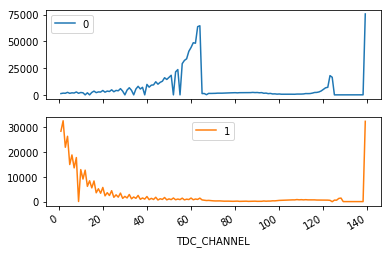

FPGA,0,1
TDC_CHANNEL,,
1,1215.0,28438.0
2,1602.0,32669.0
3,1493.0,21970.0
4,2352.0,26403.0
5,1432.0,15003.0
6,1914.0,18869.0
7,1733.0,13646.0
8,2711.0,17813.0
9,1460.0,80.0


In [8]:
#grouping by fpga and tdc chan: the resulting multiindex separates the dataset into two parts, each of them
#with the number of counts per tdc chan
datachan = data_tot.groupby(['FPGA','TDC_CHANNEL']).sum()

#producing two subplots after unstacking
#fillna is used as not every channel of both fpga has captured an event
datachan.unstack('FPGA')['HEAD'].fillna(value=0).plot(subplots = True)

plt.show()
datachan.unstack('FPGA')['HEAD'].fillna(value=0)

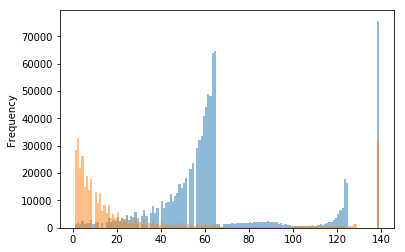

In [9]:
#using histograms
g = data_tot.groupby(['FPGA'])
n_bins = data_tot.TDC_CHANNEL.max()-data_tot.TDC_CHANNEL.min()
g.TDC_CHANNEL.plot(kind = 'hist', bins = n_bins, alpha = 0.5)
plt.show()

# EX 8

In [11]:
#number of 'most noisy' channels
num_noise = 5

#given the number n, it gives back the associated ordinal; for example, ordinal(5) = 5th
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4]) 

#dictionaries for future use in renaming rows and columns of the final dataframe
index_c = {0: 'FPGA', 1:'TDC_CHANNEL'}
index_r = {i: ordinal(i+1) for i in range(num_noise)}

#grouped data
datanoise = data_tot.groupby(['FPGA','TDC_CHANNEL']).sum()

#list of the three couples (fpga, channel)
noisy = [pd.DataFrame([datanoise['HEAD'].nlargest(num_noise).index]).T.unstack().iloc[i] for i in range(num_noise)]

#separation of the couples and creation of a nicer dataframe
noisy = pd.DataFrame(noisy).rename(index = index_r, columns = index_c)
noisy


,FPGA,TDC_CHANNEL
1st,0,139
2nd,0,64
3rd,0,63
4th,0,61
5th,0,62


# EX 9

In [12]:
#grouping by orbit count

num_orb = data_tot.groupby('ORBIT_CNT').sum()['HEAD']
#print(num_orb)

#meaning number of orbits which appear only once in the database
un_orb = num_orb[num_orb == 1]
print('Number of unique orbits: ',un_orb.sum()) 

#meaning the number of distinct orbits
dist_orb = num_orb.count()
print('Number of distinct orbits: ',dist_orb) 

#counts from 139
data_139 = data_tot[data_tot['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').sum()['HEAD']
dist_orb_139 = data_139.count()
print('Number of distinct orbits having at least one count from TDC_CHANNEL 139: ',dist_orb_139)

Number of unique orbits:  2
Number of distinct orbits:  11001
Number of distinct orbits having at least one count from TDC_CHANNEL 139:  10976
